In [ ]:
# change the output font size
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 20px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
!pip install transformers

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp313-cp313-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/torchvision-0.2.0-py2.py3-none-any.whl (48 kB)
ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import AdamW

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
# hide warnings
import warnings
warnings.filterwarnings('ignore')
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)  # For CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # For all GPUs

In [ ]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Preprocessing

In [ ]:

main_df = pd.read_csv('./data/Cyberbullying_dataset.csv', sep = '\t')

# Let's see how many smaples we have
print('Total number of samples:', main_df.shape)
main_df = main_df.sample(n = main_df.shape[0])
main_df = main_df[['text', 'label']]

# Let's take a look at a few samples from our dataset
print(main_df.head())

Total number of samples: (13159, 2)
                                                    text  label
7351   Q: yu always tell me how much you loves meh<br...      0
6401   Q: my day has been fine thanks  its nearly 11p...      0
389    Q: If you could BE any Skins character  who wo...      0
3173   Q: Favourite website on the net?<br>A: formspr...      0
10677  Q: hold on... cute in what way?<br>A: Cute cut...      0


Note:
* 0 indicates non-cyberbullying
* 1 indicates cyberbullying

In [ ]:
# let's divide the dataset into non-cyberbullying and cyberbullying samples
o_class = main_df.loc[main_df.label == 0, :]
l_class = main_df.loc[main_df.label == 1, :]

# let's create train, val and test splits
train_val = main_df.iloc[:int(main_df.shape[0] * .80)]
test_df = main_df.iloc[int(main_df.shape[0] * .80):]
train_df = train_val.iloc[:int(train_val.shape[0] * .80)]
val_df = train_val.iloc[int(train_val.shape[0] * .80):]

#print(train.shape, val.shape, test.shape)
print('\nTraining set:\n', train_df.label.value_counts())
print('\nValidation set:\n', val_df.label.value_counts())
print('\nTest set:\n', test_df.label.value_counts())


Training set:
 label
0    7869
1     552
Name: count, dtype: int64

Validation set:
 label
0    1972
1     134
Name: count, dtype: int64

Test set:
 label
0    2450
1     182
Name: count, dtype: int64


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Prepare the dataset
class CyberbullyingDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text = df.text.to_list()
        self.label = df.label.to_list()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text, # Sentence to encode.
            None, # Add another sequence to the inputs. 'None' means no other sequence is added.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = self.max_len, # Pad & truncate all sentences.
            pad_to_max_length = True, # Pad all samples to the same length.
            truncation = True, # Truncate all samples to the same length.
            return_token_type_ids = False,
            return_tensors = 'pt' # Return pytorch tensors.
        )
        label = torch.tensor(self.label[index], dtype = torch.long)

        return {
            'text': text,
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': label
        }

# The number of unique words in the vocabulary and the number of labels
VOCAB_SIZE = tokenizer.vocab_size
NUM_LABELS = train_df.label.nunique()
print("The number of unique words in the vocabulary:", VOCAB_SIZE)
print("The number of labels:", NUM_LABELS)

The number of unique words in the vocabulary: 30522
The number of labels: 2


In order to make the model understand both cyberbullying and non-cyberbullying data, we typically balance the datasets.

In [ ]:
# Build a balanced dataset
def balence_data(dataframe):
    o_class = dataframe.loc[dataframe.label == 0, :]
    l_class = dataframe.loc[dataframe.label == 1, :]
    o_class = o_class.sample(n = l_class.shape[0])
    dataframe = pd.concat([o_class, l_class], axis = 0)
    dataframe = dataframe.sample(n = dataframe.shape[0])
    return dataframe

train_df = balence_data(train_df)
val_df = balence_data(val_df)
test_df = balence_data(test_df)

print('\nTraining set:\n', train_df.label.value_counts())
print('\nValidation set:\n', val_df.label.value_counts())
print('\nTest set:\n', test_df.label.value_counts())


Training set:
 label
0    552
1    552
Name: count, dtype: int64

Validation set:
 label
1    134
0    134
Name: count, dtype: int64

Test set:
 label
1    182
0    182
Name: count, dtype: int64


In [ ]:
# Normally, we prepare the dataset with batches, it can help us to train the model faster.
MAX_LEN = 120
BATCH_SIZE = 32

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CyberbullyingDataset(df, tokenizer, max_len)
    return DataLoader(ds, batch_size = batch_size)

# Create the dataloaders
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

print("After we build the dataloaders, we can see the number of batches in each dataloader. It means we can train the model with {} samples in each time.".format(BATCH_SIZE))
print("The number of batches in the training dataloader:", len(train_data_loader))
print("The number of batches in the validation dataloader:", len(val_data_loader))
print("The number of batches in the test dataloader:", len(test_data_loader))

After we build the dataloaders, we can see the number of batches in each dataloader. It means we can train the model with 32 samples in each time.
The number of batches in the training dataloader: 35
The number of batches in the validation dataloader: 9
The number of batches in the test dataloader: 12


### AI Model Definition

In [ ]:
# defining hyperparameters
N_EPOCHS = 5 # The number of epochs
LEARNING_RATE = 2e-5 # The learning rate
Num_classes = 2 # The number of classes

In [ ]:
# Download the tokenizer and model
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
bert_model = bert_model.to(device)

In [ ]:
# Define the model
class CyberbullyingDetecter(nn.Module):
    def __init__(self, bert_model, Num_classes):
            super(CyberbullyingDetecter, self).__init__()
            self.bert = bert_model
            self.drop = nn.Dropout(p=0.3)
            self.out = nn.Linear(self.bert.config.hidden_size, Num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )['pooler_output']
        output = self.drop(pooled_output)
        return self.out(output)

# Create the model
model = CyberbullyingDetecter(bert_model, Num_classes)
model = model.to(device)

In [ ]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

In [ ]:
# Let's define the training and testing procedures for our AI model
# Lets define our training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['label'].to(device)
    # print(inputs_ids.shape, attention_mask.shape, label.shape)
    outputs = model(inputs_ids, attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define our testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = model(inputs_ids, attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# define a function for evaluation
def predict_cb(sentence):
    sentence = str(sentence)
    sentence = ' '.join(sentence.split())
    inputs = tokenizer.encode_plus(
        sentence, # Sentence to encode.
        None, # Add another sequence to the inputs. 'None' means no other sequence is added.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN, # Pad & truncate all sentences.
        pad_to_max_length = True, # Pad all samples to the same length.
        truncation = True, # Truncate all samples to the same length.
        return_token_type_ids = True # Return token_type_ids
    )
    output = model(torch.tensor(inputs['input_ids']).unsqueeze(0).to(device), torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device))
    # print(output)
    preds, ind= torch.max(F.softmax(output, dim=-1), 1)
    if ind.item() == 1:
        return preds, ind, 'Cyberbullying detected.'
    else:
        return preds, ind, 'Cyberbullying not detected.'

### Training Process

In [ ]:
# Let's train our model
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.564 | Train Acc: 70.45% | Val. Loss: 0.373 | Val. Acc: 82.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.321 | Train Acc: 87.05% | Val. Loss: 0.380 | Val. Acc: 86.11% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.123 | Train Acc: 96.34% | Val. Loss: 0.544 | Val. Acc: 85.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.056 | Train Acc: 98.48% | Val. Loss: 0.572 | Val. Acc: 85.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.024 | Train Acc: 99.11% | Val. Loss: 0.750 | Val. Acc: 83.10% |


### Model Evaluation

In [ ]:
#TODO: add your code below to print the final training accuracy out
print(f'Final Training Accuracy: {train_acc*100:.2f}%')

Final Training Accuracy: 99.11%


In [ ]:
test_loss, test_acc = evaluate(model, test_data_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

| Test Loss: 0.741 | Test Acc: 83.25% |


### Inference

In [ ]:
#TODO: complete the code below
# Sample texts
text1 = "you guys are a bunch of losers, fuck you"
ret1 = predict_cb(text1)
print(f"Text: {text1}\nPrediction: {ret1[2]} | Confidence: {ret1[0].item() * 100:.2f}%")

print("=========================================")

text2 = "I'm never going to see your little pathetic self again"
ret2 = predict_cb(text2)
print(f"Text: {text2}\nPrediction: {ret2[2]} | Confidence: {ret2[0].item() * 100:.2f}%")

print("=========================================")

text3 = "She looks really nice today!"
ret3 = predict_cb(text3)
print(f"Text: {text3}\nPrediction: {ret3[2]} | Confidence: {ret3[0].item() * 100:.2f}%")

Text: you guys are a bunch of losers, fuck you
Prediction: Cyberbullying detected. | Confidence: 99.04%
Text: I'm never going to see your little pathetic self again
Prediction: Cyberbullying detected. | Confidence: 99.95%
Text: She looks really nice today!
Prediction: Cyberbullying not detected. | Confidence: 99.84%


## Hyperparameter Tuning

In [ ]:
# @title A fast training function
def train_model(model, train_data_loader, val_data_loader, number_of_epochs, learning_rate, verbose=True):
    """
    Trains our AI model and plots the learning curve
    Arguments:
        model: model to be trained
        train_iterator: an iterator over the training set
        validation_iterator: an iterator over the validation set
        number_of_epochs: The number of times to go through our entire dataset
        optimizer: the optimization function, defaults to None
        criterion: the loss function, defaults to None
        learning_rate: the learning rate, defaults to 0.001
        verbose: Boolean - whether to print accuracy and loss
    Returns:
        learning_curve: Dictionary - contains variables for plotting the learning curve
    """

    # initialize variables for plotting
    epochs = [i for i in range(number_of_epochs)]
    train_losses = []
    validation_losses = []
    validation_accs = []

    # define the optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
    criterion = nn.CrossEntropyLoss().to(device)

    model = model.to(device)

    # train the model
    for epoch in range(number_of_epochs):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)
        train_losses.append(train_loss)
        validation_losses.append(valid_loss)
        validation_accs.append(valid_acc)
        if verbose:
            print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

    test_loss, test_acc = evaluate(model, test_data_loader, criterion)
    if verbose:
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
    print()

    epochs = np.asarray(epochs)
    train_losses = np.asarray(train_losses)
    validation_losses = np.asarray(validation_losses)
    validation_accs = np.asarray(validation_accs)

    learning_curve = {
        'epochs': epochs,
        'train_losses': train_losses,
        'validation_losses': validation_losses,
        'validation_accs': validation_accs,
        'learning_rate': learning_rate,
    }

    return learning_curve


**Finding a suitable epoch number**


In [ ]:
training_epochs = range(2,12)
learning_curve = {}

for i, epoch in enumerate(training_epochs,1):
    print(f'Training for {epoch} epochs')
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve[i] = train_model(model, train_data_loader, val_data_loader, epoch, 2e-5, verbose=True)
    print('training complete!')


Training for 2 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.552 | Train Acc: 71.96% | Val. Loss: 0.400 | Val. Acc: 82.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.330 | Train Acc: 86.96% | Val. Loss: 0.415 | Val. Acc: 84.61% |
Test Loss: 0.374 | Test Acc: 84.72% |

training complete!
Training for 3 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.674 | Train Acc: 57.05% | Val. Loss: 0.525 | Val. Acc: 77.43% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.452 | Train Acc: 80.89% | Val. Loss: 0.364 | Val. Acc: 86.81% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.297 | Train Acc: 88.84% | Val. Loss: 0.417 | Val. Acc: 82.99% |
Test Loss: 0.471 | Test Acc: 83.59% |

training complete!
Training for 4 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.666 | Train Acc: 57.23% | Val. Loss: 0.550 | Val. Acc: 75.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.450 | Train Acc: 80.80% | Val. Loss: 0.428 | Val. Acc: 82.87% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.273 | Train Acc: 90.89% | Val. Loss: 0.368 | Val. Acc: 85.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.143 | Train Acc: 95.54% | Val. Loss: 0.488 | Val. Acc: 83.10% |
Test Loss: 0.469 | Test Acc: 85.50% |

training complete!
Training for 5 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.575 | Train Acc: 69.11% | Val. Loss: 0.445 | Val. Acc: 80.09% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.352 | Train Acc: 85.98% | Val. Loss: 0.478 | Val. Acc: 82.52% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.183 | Train Acc: 93.39% | Val. Loss: 0.464 | Val. Acc: 82.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.058 | Train Acc: 98.21% | Val. Loss: 0.639 | Val. Acc: 83.80% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.016 | Train Acc: 99.55% | Val. Loss: 0.760 | Val. Acc: 82.75% |
Test Loss: 0.812 | Test Acc: 83.25% |

training complete!
Training for 6 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.598 | Train Acc: 68.84% | Val. Loss: 0.396 | Val. Acc: 84.84% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.370 | Train Acc: 84.91% | Val. Loss: 0.372 | Val. Acc: 86.81% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.209 | Train Acc: 92.86% | Val. Loss: 0.536 | Val. Acc: 83.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.137 | Train Acc: 95.27% | Val. Loss: 0.533 | Val. Acc: 83.68% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.083 | Train Acc: 97.32% | Val. Loss: 0.692 | Val. Acc: 81.83% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.016 | Train Acc: 99.64% | Val. Loss: 0.793 | Val. Acc: 82.41% |
Test Loss: 0.752 | Test Acc: 84.29% |

training complete!
Training for 7 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.613 | Train Acc: 65.36% | Val. Loss: 0.368 | Val. Acc: 84.84% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.351 | Train Acc: 85.27% | Val. Loss: 0.510 | Val. Acc: 83.45% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.138 | Train Acc: 95.09% | Val. Loss: 0.560 | Val. Acc: 83.68% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.085 | Train Acc: 97.23% | Val. Loss: 0.782 | Val. Acc: 78.82% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.050 | Train Acc: 98.75% | Val. Loss: 0.706 | Val. Acc: 83.22% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.032 | Train Acc: 99.29% | Val. Loss: 0.637 | Val. Acc: 85.07% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.027 | Train Acc: 99.46% | Val. Loss: 0.650 | Val. Acc: 84.38% |
Test Loss: 0.646 | Test Acc: 86.72% |

training complete!
Training for 8 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.616 | Train Acc: 63.75% | Val. Loss: 0.399 | Val. Acc: 83.80% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.384 | Train Acc: 84.46% | Val. Loss: 0.421 | Val. Acc: 85.88% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.231 | Train Acc: 91.52% | Val. Loss: 0.499 | Val. Acc: 83.56% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.124 | Train Acc: 96.07% | Val. Loss: 0.542 | Val. Acc: 84.72% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.065 | Train Acc: 98.57% | Val. Loss: 0.709 | Val. Acc: 84.03% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.055 | Train Acc: 98.84% | Val. Loss: 0.634 | Val. Acc: 85.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.052 | Train Acc: 98.66% | Val. Loss: 0.615 | Val. Acc: 84.72% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.028 | Train Acc: 99.38% | Val. Loss: 0.748 | Val. Acc: 84.38% |
Test Loss: 0.705 | Test Acc: 84.55% |

training complete!
Training for 9 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.560 | Train Acc: 68.48% | Val. Loss: 0.391 | Val. Acc: 82.52% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.286 | Train Acc: 88.21% | Val. Loss: 0.451 | Val. Acc: 86.81% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.170 | Train Acc: 94.55% | Val. Loss: 0.518 | Val. Acc: 82.64% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.065 | Train Acc: 98.21% | Val. Loss: 0.721 | Val. Acc: 80.09% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.035 | Train Acc: 99.02% | Val. Loss: 0.715 | Val. Acc: 80.21% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.012 | Train Acc: 99.82% | Val. Loss: 0.812 | Val. Acc: 80.90% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.004 | Train Acc: 99.91% | Val. Loss: 0.889 | Val. Acc: 80.90% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.001 | Train Acc: 100.00% | Val. Loss: 0.966 | Val. Acc: 81.48% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.001 | Train Acc: 100.00% | Val. Loss: 1.008 | Val. Acc: 80.79% |
Test Loss: 0.844 | Test Acc: 85.68% |

training complete!
Training for 10 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.578 | Train Acc: 67.86% | Val. Loss: 0.366 | Val. Acc: 84.03% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.299 | Train Acc: 87.68% | Val. Loss: 0.416 | Val. Acc: 86.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.106 | Train Acc: 96.43% | Val. Loss: 0.874 | Val. Acc: 78.12% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.093 | Train Acc: 96.61% | Val. Loss: 0.527 | Val. Acc: 82.06% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.037 | Train Acc: 98.93% | Val. Loss: 0.685 | Val. Acc: 82.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.018 | Train Acc: 99.38% | Val. Loss: 0.739 | Val. Acc: 81.13% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.011 | Train Acc: 99.73% | Val. Loss: 0.816 | Val. Acc: 82.75% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.001 | Train Acc: 100.00% | Val. Loss: 0.837 | Val. Acc: 84.14% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.001 | Train Acc: 99.91% | Val. Loss: 0.895 | Val. Acc: 83.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.001 | Train Acc: 100.00% | Val. Loss: 0.927 | Val. Acc: 83.10% |
Test Loss: 0.849 | Test Acc: 84.46% |

training complete!
Training for 11 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.705 | Train Acc: 50.45% | Val. Loss: 0.667 | Val. Acc: 52.78% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.508 | Train Acc: 75.18% | Val. Loss: 0.427 | Val. Acc: 85.19% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.262 | Train Acc: 90.45% | Val. Loss: 0.487 | Val. Acc: 83.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.127 | Train Acc: 95.89% | Val. Loss: 0.574 | Val. Acc: 80.67% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.045 | Train Acc: 99.02% | Val. Loss: 0.927 | Val. Acc: 80.09% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.032 | Train Acc: 99.29% | Val. Loss: 0.854 | Val. Acc: 80.90% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.024 | Train Acc: 99.46% | Val. Loss: 0.893 | Val. Acc: 81.37% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.045 | Train Acc: 98.75% | Val. Loss: 0.829 | Val. Acc: 78.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.031 | Train Acc: 99.02% | Val. Loss: 0.963 | Val. Acc: 78.94% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.018 | Train Acc: 99.46% | Val. Loss: 0.905 | Val. Acc: 80.21% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 0.012 | Train Acc: 99.20% | Val. Loss: 1.019 | Val. Acc: 81.60% |
Test Loss: 0.910 | Test Acc: 82.55% |

training complete!


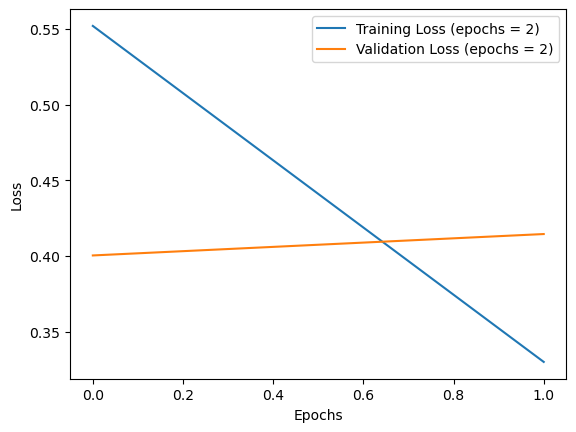

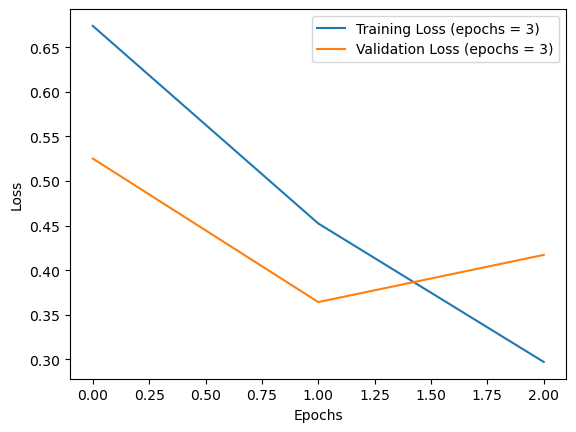

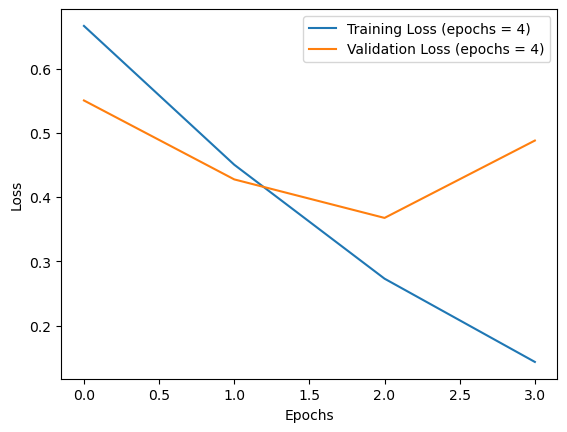

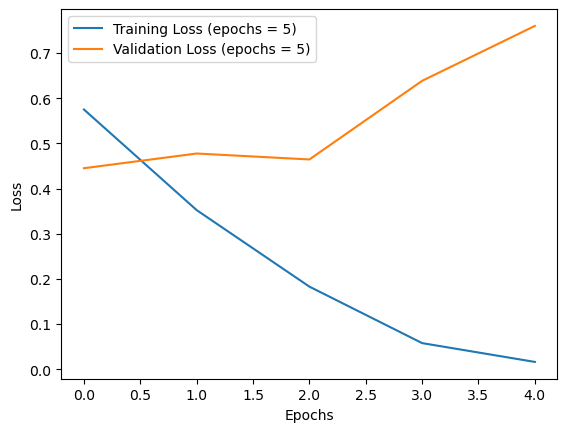

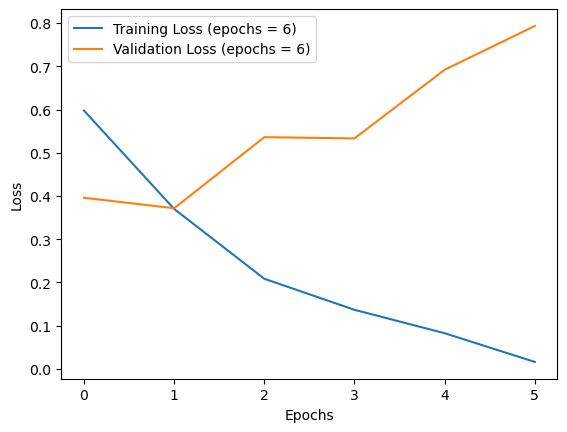

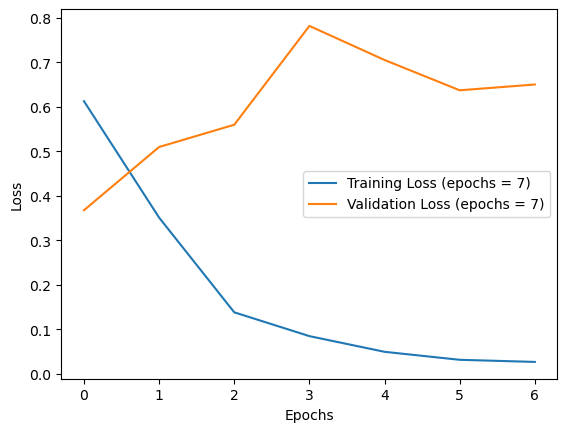

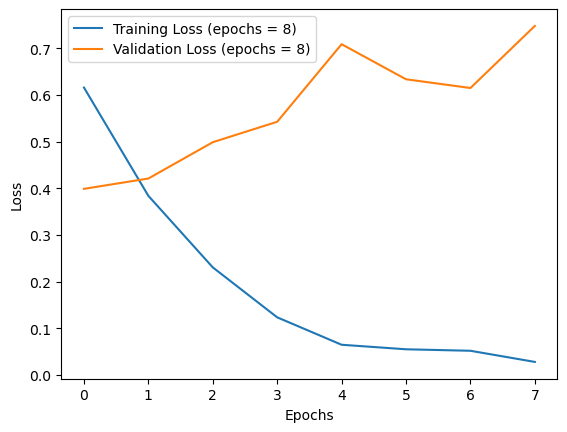

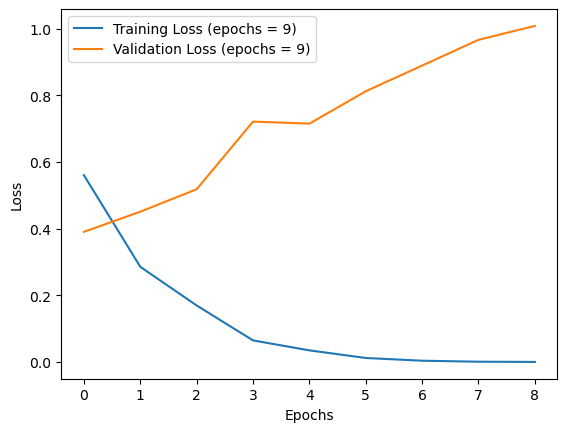

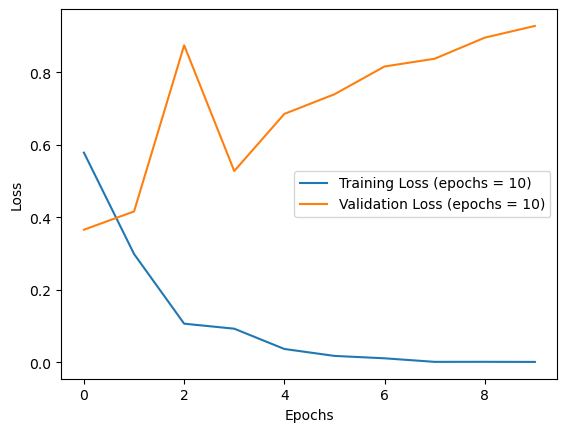

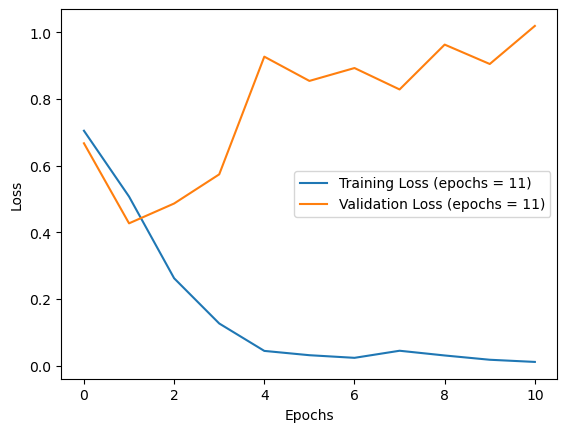

In [ ]:
for i, epoch in enumerate(training_epochs,1):
    plt.plot(learning_curve[i]['epochs'], learning_curve[i]['train_losses'], label=f'Training Loss (epochs = {epoch})')
    plt.plot(learning_curve[i]['epochs'], learning_curve[i]['validation_losses'], label=f'Validation Loss (epochs = {epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

**Inference** : Optimal number of epochs based on learning curve is 7

**Tuning learning rate**

In [ ]:
learning_rates = [0.1,1e-3,1e-5,2e-5,2e-6]
learning_curve = {}

for i, lr in enumerate(learning_rates,1):
    print('Learning rate:', lr)
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve[i] = train_model(model, train_data_loader, val_data_loader, 7, lr, verbose=True)
    print('Training complete!')

Learning rate: 0.1


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 55.370 | Train Acc: 50.36% | Val. Loss: 77.733 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 54.488 | Train Acc: 48.21% | Val. Loss: 2.844 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 19.480 | Train Acc: 46.79% | Val. Loss: 23.364 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 21.752 | Train Acc: 51.07% | Val. Loss: 5.759 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 16.691 | Train Acc: 50.98% | Val. Loss: 6.219 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 13.035 | Train Acc: 50.89% | Val. Loss: 11.718 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 11.375 | Train Acc: 47.95% | Val. Loss: 6.556 | Val. Acc: 50.00% |
Test Loss: 6.613 | Test Acc: 49.57% |

Training complete!
Learning rate: 0.001


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.067 | Train Acc: 49.11% | Val. Loss: 0.699 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.801 | Train Acc: 49.55% | Val. Loss: 0.705 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.781 | Train Acc: 48.30% | Val. Loss: 0.702 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.784 | Train Acc: 51.43% | Val. Loss: 0.703 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.753 | Train Acc: 52.50% | Val. Loss: 0.697 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.804 | Train Acc: 48.39% | Val. Loss: 0.732 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.783 | Train Acc: 49.11% | Val. Loss: 0.769 | Val. Acc: 50.00% |
Test Loss: 0.765 | Test Acc: 50.43% |

Training complete!
Learning rate: 1e-05


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.599 | Train Acc: 64.46% | Val. Loss: 0.396 | Val. Acc: 84.03% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.387 | Train Acc: 83.84% | Val. Loss: 0.435 | Val. Acc: 83.80% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.210 | Train Acc: 92.50% | Val. Loss: 0.497 | Val. Acc: 82.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.104 | Train Acc: 97.05% | Val. Loss: 0.524 | Val. Acc: 83.68% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.055 | Train Acc: 98.39% | Val. Loss: 0.706 | Val. Acc: 82.75% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.027 | Train Acc: 99.29% | Val. Loss: 0.694 | Val. Acc: 83.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.016 | Train Acc: 99.64% | Val. Loss: 0.699 | Val. Acc: 83.33% |
Test Loss: 0.659 | Test Acc: 86.02% |

Training complete!
Learning rate: 2e-05


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.604 | Train Acc: 64.55% | Val. Loss: 0.414 | Val. Acc: 80.67% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.357 | Train Acc: 85.62% | Val. Loss: 0.383 | Val. Acc: 86.57% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.166 | Train Acc: 93.39% | Val. Loss: 0.543 | Val. Acc: 80.79% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.073 | Train Acc: 97.59% | Val. Loss: 0.594 | Val. Acc: 83.56% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.014 | Train Acc: 99.55% | Val. Loss: 0.753 | Val. Acc: 82.87% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.010 | Train Acc: 99.64% | Val. Loss: 0.795 | Val. Acc: 82.75% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.005 | Train Acc: 99.91% | Val. Loss: 0.936 | Val. Acc: 81.94% |
Test Loss: 0.765 | Test Acc: 84.46% |

Training complete!
Learning rate: 2e-06


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.673 | Train Acc: 57.86% | Val. Loss: 0.605 | Val. Acc: 67.48% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.519 | Train Acc: 76.96% | Val. Loss: 0.473 | Val. Acc: 77.78% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.395 | Train Acc: 85.09% | Val. Loss: 0.425 | Val. Acc: 81.60% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.307 | Train Acc: 89.20% | Val. Loss: 0.457 | Val. Acc: 82.64% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.261 | Train Acc: 90.71% | Val. Loss: 0.415 | Val. Acc: 82.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.191 | Train Acc: 94.38% | Val. Loss: 0.429 | Val. Acc: 83.68% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.166 | Train Acc: 95.27% | Val. Loss: 0.457 | Val. Acc: 82.64% |
Test Loss: 0.425 | Test Acc: 84.20% |

Training complete!


**Inference** : 1e-5 turned out to be the best learning rate

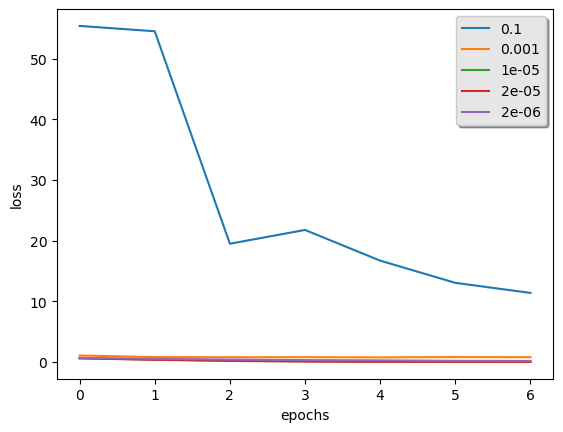

In [ ]:
for i, lr in enumerate(learning_rates,1):
    plt.plot(learning_curve[i]["epochs"], np.squeeze(learning_curve[i]["train_losses"]), label=learning_curve[i]["learning_rate"])

plt.ylabel('loss')
plt.xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Hyperparameter tuning is crucial for improving AI model performance. Here's what we observed:

1. **Number of Epochs:**
   - **Before Tuning (5 epochs):** The model undertrained, leading to lower validation accuracy.
   - **After Tuning (7 epochs):** Longer training allowed the model to learn better, improving accuracy.

2. **Learning Rate:**
   - **Before Tuning (2e-5):** The learning rate was suboptimal, limiting performance.
   - **After Tuning (1e-5):** A lower learning rate improved training stability and accuracy.

3. **Overall Impact:**
   - **Before Tuning:** Test accuracy was around 83.25%.
   - **After Tuning:** Test accuracy increased to about 86%, showing the importance of adjusting hyperparameters.

In summary, fine-tuning the number of epochs and learning rate led to better model performance by allowing it to learn more effectively and converge to a better solution.